In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, utils, losses, callbacks
import tensorflow_hub as hub
import tensorboard
import tensorflow_docs as tfds 
import tensorflow_docs.modeling
import tensorflow_docs.plots

import matplotlib.pyplot as plt

import pandas as pd
import string, re
import spacy
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS
import itertools
from autocorrect import Speller

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from math import ceil



In [2]:
df = pd.read_csv("data.csv").drop("index",axis=1)

# Data Exploration

In [3]:
df.head()

,title,genre,summary
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4657 entries, 0 to 4656
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4657 non-null   object
 1   genre    4657 non-null   object
 2   summary  4657 non-null   object
dtypes: object(3)
memory usage: 109.3+ KB


In [5]:
df.genre.value_counts(True)*100

thriller      21.966932
fantasy       18.810393
science       13.893064
history       12.883831
horror        12.883831
crime         10.736526
romance        2.383509
psychology     2.147305
sports         2.147305
travel         2.147305
Name: genre, dtype: float64

In [6]:
df.summary[0]

' Drowned Wednesday is the first Trustee among the Morrow Days who is on Arthur\'s side and wishes the Will to be fulfilled. She appears as a leviathan/whale and suffers from Gluttony. The book begins when Leaf is visiting Arthur and they are discussing the invitation that Drowned Wednesday sent him. Arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter Tuesday\'s Treasure Tower. Suddenly, the hospital room becomes flooded with water as the two are transported to the Border Sea of the House. Leaf is snatched away by a large ship with green sails, known as the Flying Mantis, while Arthur remains in his bed. When the Medallion given him by the immortal called the Mariner apparently fails to summon help, Arthur is without hope. Eventually, a buoy marking the pirate Elishar Feverfew\'s treasure floats toward him. As soon as Arthur opens it, his hand is marked with a bloody red colour. Arthur now has the Red Hand, by which Feverfew marks whoev

# Data Cleaning

In [7]:
stop_w = STOP_WORDS
chat_words_map_dict = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
}

class Text_cleaner :
    def __init__(self) -> None:
        self.nlp = spacy.load("en_core_web_sm",) #exclude=[ "parser", "attribute_ruler", "ner"])#"lemmatizer" "tagger"

    def remove_html_tags(self, text:str) -> str:
        return re.sub('"', "", text)

    def remove_url_email_num_stop_chat(self, text:str) -> str:
        new_text = []
        #text = tf.compat.as_str_any(text)
        doc = self.nlp(text)
        for token in doc:
            to_remove = False
            # remove_url_email_num_stop
            if any([token.like_url, token.like_email, token.like_num, token.is_stop]):
                to_remove = True
            #elif token.text.lower() in stop_w:
            #    to_remove = True

            if not to_remove:
                # replace_chat_words
                if token.text.upper() in chat_words_map_dict.keys():
                    new_text.append(
                            chat_words_map_dict[token.text.upper()])
                # ajust punctions
                elif token.is_punct :
                    if len(new_text) > 0 and string.punctuation.__contains__(new_text[-1][-1]):
                        continue
                    if not any([token.is_bracket,token.is_quote,]) and len(new_text) > 0:
                        new_text[-1] = new_text[-1]+token.text
                    else:
                        new_text.append(token.lemma_)
                else:
                    new_text.append(token.lemma_)

        return " ".join(new_text)

    def lemma(self, text:str)->str:
        new_text = []
        doc = self.nlp(text)
        for token in doc:
            if token.is_punct:
                continue
            new_text.append(token.lemma_)

        return " ".join(new_text)

    def spelling_check(self, text:str) -> str:
        text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
        spell = Speller(lang='en')
        text = spell(text)
        return text


    def perform_cleaning(self, text:str, lower:bool=True, spelling_check:bool=False) -> str:
        if spelling_check:
            text = self.spelling_check(text)
        text = self.remove_html_tags(text)
        text = self.remove_url_email_num_stop_chat(text)
        text = self.lemma(text)

        if lower:
            return text.lower()
            
        return text
    


In [8]:
Text_cleaner().perform_cleaning(df.summary[0])

'   drown wednesday trustee morrow days arthur wish fulfil appear leviathan/ whale suffer gluttony book begin leaf visit arthur discuss invitation drown wednesday send arthur admit hospital damage leg attempt enter tuesday treasure tower suddenly hospital room flood water transport border sea house leaf snatch away large ship green sail know flying mantis arthur remain bed medallion give immortal call mariner apparently fail summon help arthur hope eventually buoy mark pirate elishar feverfew treasure float soon arthur open hand mark bloody red colour arthur red hand feverfew mark find treasure identify later long scavenge ship call moth rescues arthur board arthur go arth introduce sunscorch mate captain catapillow journey bring line storms border sea later pursue feverfew ghostly ship shiver damage inflict moth sunscorch command upper house sorcerer dr. scamandros open transfer portal secondary realms scamandro claim arthur carry interfere magic tell sunscorch throw overboard resort 

In [9]:
cleaner = Text_cleaner()

In [10]:
df["summary_cleaned"] = df.summary.apply(cleaner.perform_cleaning)
df.head(5)


,title,genre,summary,summary_cleaned
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,drown wednesday trustee morrow days arthur ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",book open jason awaken school bus unable re...
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...,cugel easily persuade merchant fianosther a...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...,book open herald- mage vanyel return countr...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...,taran gurgi return caer dallben follow even...


In [11]:
df.groupby("genre")["title"].apply(list)


genre
crime         [The Broken Shore, At Bertram's Hotel, Leviath...
fantasy       [Drowned Wednesday, The Lost Hero, The Eyes of...
history       [Smuggler's Moon, An Experiment In Treason, Wa...
horror        [The Strange Case of Dr Jekyll and Mr Hyde, Th...
psychology    [Thinking, Fast and Slow, Man's Search for Mea...
romance       [Pride and Prejudice, The Fault in Our Stars, ...
science       [Starcross, Glasshouse, Rocheworld, Master of ...
sports        [Moneyball: The Art of Winning an Unfair Game,...
thriller      [Violets are Blue, A Prisoner of Birth, Step o...
travel        [A Walk in the Woods: Rediscovering America on...
Name: title, dtype: object

# Data Preparation

In [12]:
encoder = LabelEncoder()
df["genre_encoded"] = encoder.fit_transform(df.genre)


In [13]:
max_features = 10000
sequence_length = 1000

vectorize_layer = layers.TextVectorization(
    #standardize=cleaner.perform_cleaning,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)


def vectorize_text(text, label):
  #text = tf.expand_dims(text, -1)
  #label = tf.expand_dims(label, -1)
  return vectorize_layer(text), label


In [14]:
dataset = tf.data.Dataset.from_tensor_slices(
    (df.summary_cleaned, df.genre_encoded)
)
dataset = dataset.shuffle(len(dataset), 100)

In [15]:
n_train = ceil(.8*len(dataset))
raw_train_ds = dataset.take(n_train)
raw_val_ds = dataset.skip(n_train)


In [16]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64

train_ds = train_ds.cache().prefetch(
    buffer_size=AUTOTUNE).batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)


# Training

In [19]:
%load_ext tensorboard 


In [20]:
logs_dir = "logs"
%tensorboard --logdir logs_dir


Reusing TensorBoard on port 6006 (pid 11384), started 12:52:59 ago. (Use '!kill 11384' to kill it.)

# Simple model

In [50]:
embedding_dim = 50
input_dim = max_features + 1

basic_model = tf.keras.Sequential([
    #vectorize_layer,
    #layers.Input((1000)),
    layers.Embedding(input_dim=input_dim ,output_dim=embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(10)
  ])

basic_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          500050    
                                                                 
 dropout_2 (Dropout)         (None, None, 50)          0         
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
Total params: 500,560
Trainable params: 500,560
Non-trainable params: 0
________________________________________________

In [51]:
basic_model.compile(loss=losses.SparseCategoricalCrossentropy(True),
             optimizer='adam',
             metrics=['accuracy'])


In [52]:
histories = {}

In [53]:
epochs = 30

histories["basic_model"] = basic_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, batch_size=batch_size,
    callbacks=[
        callbacks.TensorBoard(f"{logs_dir}/basic_model"),
        callbacks.EarlyStopping(monitor="val_loss", patience=10)
    ],
)  # batch_size=30


Epoch 1/30
59/59 [==============================] - 5s 73ms/step - loss: 2.2390 - accuracy: 0.2040 - val_loss: 2.1677 - val_accuracy: 0.2191
Epoch 2/30
59/59 [==============================] - 6s 97ms/step - loss: 2.1135 - accuracy: 0.2335 - val_loss: 2.0699 - val_accuracy: 0.2202
Epoch 3/30
59/59 [==============================] - 5s 90ms/step - loss: 2.0515 - accuracy: 0.2362 - val_loss: 2.0443 - val_accuracy: 0.2202
Epoch 4/30
59/59 [==============================] - 5s 86ms/step - loss: 2.0347 - accuracy: 0.2316 - val_loss: 2.0359 - val_accuracy: 0.2202
Epoch 5/30
59/59 [==============================] - 5s 83ms/step - loss: 2.0229 - accuracy: 0.2426 - val_loss: 2.0292 - val_accuracy: 0.2288
Epoch 6/30
59/59 [==============================] - 5s 82ms/step - loss: 2.0195 - accuracy: 0.2437 - val_loss: 2.0223 - val_accuracy: 0.2331
Epoch 7/30
59/59 [==============================] - 5s 79ms/step - loss: 2.0097 - accuracy: 0.2517 - val_loss: 2.0152 - val_accuracy: 0.2438
Epoch 8/30
59

In [54]:
loss, accuracy = basic_model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


15/15 [==============================] - 0s 7ms/step - loss: 1.6661 - accuracy: 0.4876
Loss:  1.666144847869873
Accuracy:  0.48764768242836


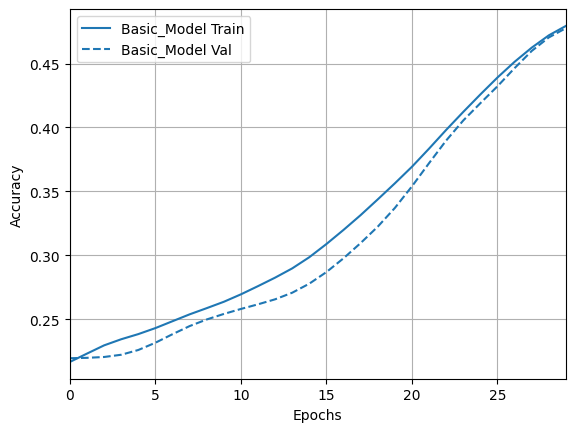

In [55]:
plotter = tfds.plots.HistoryPlotter(
    metric='accuracy', smoothing_std=10)
plotter.plot(histories)


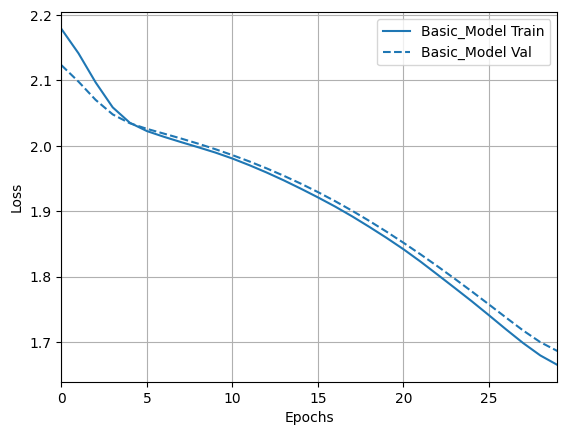

In [56]:
plotter = tfds.plots.HistoryPlotter(
    metric='loss', smoothing_std=10)
plotter.plot(histories)


In [57]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    basic_model,
    layers.Activation('softmax')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=['accuracy']
)


loss, accuracy = export_model.evaluate(raw_val_ds.batch(batch_size))
print(accuracy)


15/15 [==============================] - 1s 13ms/step - loss: 1.6122 - accuracy: 0.5134
0.5134264230728149


# Transfert Learning

In [40]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,True, input_shape=[], dtype=tf.string)

In [41]:
hub_model = keras.Sequential()
hub_model.add(hub_layer)
hub_model.add(layers.Dense(16, activation="relu"))
hub_model.add(layers.Dense(10))

In [42]:
hub_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])


In [59]:
epochs = 30
histories["hub_model"] = hub_model.fit(
    raw_train_ds.batch(batch_size),
    validation_data=raw_val_ds.batch(batch_size),
    epochs=epochs, batch_size=batch_size,
    callbacks=[
        callbacks.TensorBoard(f"{logs_dir}/hub_model"),
        callbacks.EarlyStopping(monitor="val_loss", patience=5),
        callbacks.
    ]
)  


Epoch 1/30
59/59 [==============================] - 33s 567ms/step - loss: 0.0534 - accuracy: 0.9710 - val_loss: 0.0426 - val_accuracy: 0.9796
Epoch 2/30
59/59 [==============================] - 38s 641ms/step - loss: 0.0509 - accuracy: 0.9737 - val_loss: 0.0321 - val_accuracy: 0.9828
Epoch 3/30
59/59 [==============================] - 39s 661ms/step - loss: 0.0501 - accuracy: 0.9713 - val_loss: 0.0321 - val_accuracy: 0.9860
Epoch 4/30
59/59 [==============================] - 35s 592ms/step - loss: 0.0453 - accuracy: 0.9748 - val_loss: 0.0418 - val_accuracy: 0.9796
Epoch 5/30
59/59 [==============================] - 37s 629ms/step - loss: 0.0475 - accuracy: 0.9734 - val_loss: 0.0324 - val_accuracy: 0.9839
Epoch 6/30
59/59 [==============================] - 36s 603ms/step - loss: 0.0512 - accuracy: 0.9710 - val_loss: 0.0347 - val_accuracy: 0.9828
Epoch 7/30
59/59 [==============================] - 35s 588ms/step - loss: 0.0501 - accuracy: 0.9716 - val_loss: 0.0425 - val_accuracy: 0.9742

In [65]:
loss, accuracy = hub_model.evaluate(raw_val_ds.batch(batch_size))
print(accuracy)


15/15 [==============================] - 2s 87ms/step - loss: 0.0412 - accuracy: 0.9731
0.9731471538543701


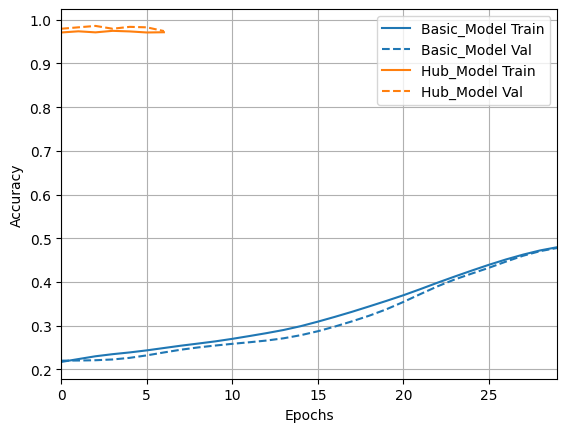

In [62]:
plotter = tfds.plots.HistoryPlotter(
    metric='accuracy', smoothing_std=10)
plotter.plot(histories)


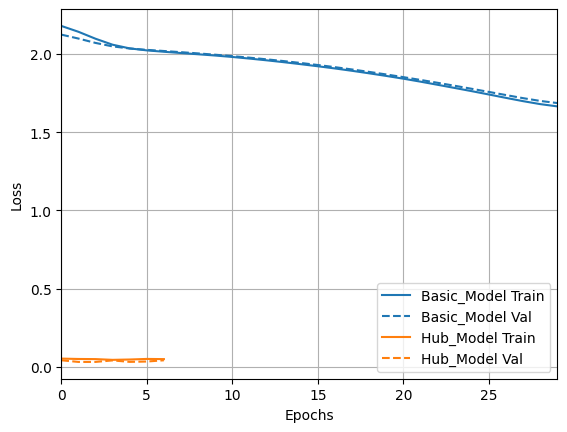

In [63]:
plotter = tfds.plots.HistoryPlotter(
    metric='loss', smoothing_std=10)
plotter.plot(histories)


# Prediction

In [47]:
df_shuffled = shuffle(df)

In [48]:
examples = df_shuffled.summary_cleaned.iloc[:4].values

results = hub_model.predict(examples)
results


1/1 [==============================] - 0s 351ms/step


array([[-1.4062402e-01, -1.8090321e+00, -1.4287335e+00,  1.2988503e+00,
        -5.4728327e+00, -8.2666731e-01, -7.5867171e+00, -4.5780811e+00,
         9.2286863e+00, -5.0588150e+00],
       [-2.9451632e+00, -4.1915151e-01,  4.9320436e+00, -3.5887332e+00,
        -3.5355549e+00, -3.6465497e+00, -1.4200643e-02, -6.4623461e+00,
        -6.7046094e-01, -1.8800799e+00],
       [-6.2369232e+00,  9.8939848e+00,  1.8017881e+00, -2.5363095e+00,
        -1.6177519e+01, -4.4030361e+00, -9.2623331e-02, -1.5821539e+01,
        -1.8948178e+00, -1.1210862e+01],
       [-6.3478765e+00, -7.4913315e-02, -3.1400239e+00, -2.7952425e+00,
        -2.9093218e+00,  5.5374751e+00, -5.9006011e-01,  2.1534875e-01,
         3.5473317e-01, -2.0712354e+00]], dtype=float32)

In [49]:
for i, res in enumerate(results):
    print("Ground trust : ",df_shuffled.genre.iloc[i])
    print("Prediction : ",encoder.inverse_transform([tf.argmax(res)]))


Ground trust :  thriller
Prediction :  ['thriller']
Ground trust :  history
Prediction :  ['history']
Ground trust :  fantasy
Prediction :  ['fantasy']
Ground trust :  romance
Prediction :  ['romance']
